# 11762 Content-Based Image Retrieval
## Master's Degree in Intelligent Systems
### University of the Balearic Islands

---

**Before you turn this problem in, please put your full names and DNIs (or NIEs) below, and execute the cell:**

In [2]:
NAME  = "Pedro Marti Pico"
DNI   = "41574536N"

NAME2 = 'Raixa Madueño Mallofré'
DNI2  = '49867599B'

Make sure you fill in any place that says `YOUR CODE HERE` or `YOUR ANSWER HERE`. **Justify** all of your answers, **graphically** wherever possible. Remember that this notebook will be considered as a report to the work done during the assignment.

---

In [1]:
# Setup code for this assignment
import cv2
import math
import numpy as np
import os
import time
import scipy.cluster.vq as vq
import tqdm
import zipfile

## Adding parent folder to find other libs
import sys
if ".." not in sys.path:
    sys.path.insert(0,"..")

import iric_dev_kit.iric_utils.eval_holidays as ev
import iric_dev_kit.iric_utils.read_descriptors as rd

# Configuring Matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

## Introduction
In this assignment, you will implement and evaluate different methods for indexing images. As usual during this course, we will use the INRIA Holidays dataset. **Check the Assignment 1 to further information about this dataset.**

We also need the provided script to evaluate a CBIR system on this dataset. Remember that the performance is measured computing the **Mean Average Precision** (mAP) over all queries. **Check also the Assignment 1 to remember how to use this script and the different functions it offers.**

### Loading images
As we did in Assignment 1, for managing images, we will create four lists:
- **`query_names`**: File names of the *query* images
- **`query_imgs`**: *Query* images loaded using OpenCV2
- **`train_names`**: File names of the *train* (database) images
- **`train_imgs`**: *Train* images loaded using OpenCV2

In this assignment, we will use the original holidays dataset:

In [ ]:
# Separating the dataset into query and train images
query_names = []
query_imgs = []
train_names = []
train_imgs = []
holidays_folder_path = '/Users/Pedro/Desktop/Master/IRIC/Practica'
with open(f'{holidays_folder_path}/holidays/holidays_images.dat') as f:
    for line in f:
        imname = line.strip()
        imno = int(imname[:-len(".jpg")])
        img = cv2.imread(f'{holidays_folder_path}/holidays/images/' + imname)
        # Resize the images for a faster operation in this assignment
        img = cv2.resize(img, None, fx=0.25, fy=0.25, interpolation = cv2.INTER_CUBIC)
    
        # Checking if this is a query image
        if imno % 100 == 0:
            query_names.append(imname)
            query_imgs.append(img)
        else:
            train_names.append(imname)
            train_imgs.append(img)

print(len(query_names))
print(len(train_names))

500
991


## Loading SIFT descriptors
In this assignment we will create four additional lists:
- **`query_kps`**: A list of lists of keypoints (cv2.KeyPoint) extracted from the *query* images
- **`query_desc`**: A list of numpy arrays including, for each set of keypoints, the SIFT descriptors extracted from the *query* images
- **`train_kps`**: A list of lists of keypoints (cv2.KeyPoint) extracted from the *train* (database) images
- **`train_desc`**: A list of numpy arrays including, for each set of keypoints, the SIFT descriptors extracted from the *train* images

Unlike in Assigment 1, now you will be provided with a set of SIFT descriptors for each image, and, therefore, you do not need to create these lists from scratch. First, download the descriptors from [here](https://uibes-my.sharepoint.com/:u:/g/personal/egf350_id_uib_eu/EYIP-UjSucZIsHL6aLNYRCcBDfBAd_42m9fHPuYB3kck4A).

> **Unzip this file into the root directory of the development kit, at the same level of the datasets.**

Now, a new directory called `siftgeo` should be in your workspace, containing the set of SIFT descriptors for each image of the dataset. These descriptors are stored in binary format and, thus, you are also provided with some tools to load them. To be more precise, you can call the function `load_SIFT_descriptors` to load the descriptors of a list of images:

In [4]:
# Loading descriptors
query_kps, query_desc = rd.load_SIFT_descriptors(query_names, max_desc=1000)
train_kps, train_desc = rd.load_SIFT_descriptors(train_names, max_desc=1000)

# Some prints
print(len(query_kps))
print(len(train_kps))
print(len(query_desc))
print(len(train_desc))
print(query_desc[0].shape)
print(query_desc[0])

500
991
500
991
(1000, 128)
[[10.  6. 52. ... 15.  4.  0.]
 [16. 50. 12. ... 15.  4.  0.]
 [10. 11. 58. ...  7.  4.  4.]
 ...
 [27. 15.  0. ... 16.  8. 12.]
 [51. 47. 14. ... 35. 26.  0.]
 [ 2. 37. 25. ... 47. 13.  8.]]


For development purposes, we use the parameter `max_desc` to load a maximum number (1000) of the descriptors. This will speed up the execution of the rest of the notebook, while the decrease in performance will be minimum.

> **Some images do not have keypoints/descriptors. Take this into account when you develop your solution.**

## $k$-d trees and LSH 
Let's start coding. At this section, you will develop a retrieval system using $k$-d trees and Locality Sensitive Hashing (LSH). 

### General framework
As we did in the first assignment, you first will develop some utilities to simplify your work. Write a function called `search_image` to search an image in a generic index (database). You should search each descriptor of the given query image and obtain its two closest SIFT descriptors in the database. Next, the initial set of matches should be filtered using the **NNDR criterion (use 0.8 as ratio)**, as you did in the previous assignment. For each database image, its final score with regard to this query image will be the **number of correct matches** with this image:

In [13]:
def search_image(descs, index, id_to_name):
    """
    Search an image in the index
    
    - descs: A numpy array. This is the set descriptors extracted from the query image
    - index: OpenCV FLANN index to search for descriptors.
    - id_to_name: An associative list to link every image index to its real name
        e.g. id_to_name[0] = '100001.jpg', id_to_name[1] = '100002.jpg'
  
    RETURN: 
    - An ordered list of similar images, e.g.: ['100101.jpg', '100202.jpg', ...]
    """
    descs = np.float32(descs)
    # Search for the closest descriptors in the index
    matches = index.knnMatch(descs, k=2)  # Get two nearest neighbors for each query descriptor
    
    # Filter matches using NNDR criterion
    good_matches = []
    for match in matches:
        if match[0].distance > match[1].distance * 0.8:  # Ratio test
            #print(f'Estoy metiendo {id_to_name[match[0].imgIdx]}')
            good_matches.append(id_to_name[match[0].imgIdx])

    # Count the number of correct matches for each database image
    image_scores = {}
    for match in good_matches:
        if match in image_scores:
            image_scores[match] += 1
        else:
            image_scores[match] = 1

    # Sort the images by their scores in descending order
    sorted_images = sorted(image_scores.items(), key=lambda x: x[1], reverse=True)

    # Extract only the image names from the sorted list
    similar_images = [image[0] for image in sorted_images]

    return similar_images


Now, write a function called `compute_mAP`. Given a list of query images and a trained index, this function should return a Python dictionary with the ordered results for each query along with the computed mAP:

In [14]:
def compute_mAP(query_names, query_desc, index, id_to_name):
    """
    Perform a search for a list of query images against the database.
    
    - query_names: An ordered list with the names of the query images
    - query_desc: A list containing numpy arrays of size (ndesc_for_this_image, 128)
                  Each numpy array i corresponds to the descriptors found at image i
    - index: FLANN index
    - id_to_name: An associative array to link every image index to its real name
                  e.g. id_to_name[0] = '100001.jpg', id_to_name[1] = '100002.jpg'
  
    RETURN: 
    - total_results: A dictionary containing, for each query image, a sorted list of the database images
    - m_ap: Mean Average Precision averaged over all queries
    """
    total_results = {}
    sum_ap = 0.0
    nqueries = len(query_names)


    # Build the ground truth relevance dictionary
    gt_relevance = {}
    for query_name in query_names:
        group_id = query_name.split('.')[0][:-2]  # Assuming group_id is part of the filename before the last two digits (ex: 100900 --> 1009001,100902)
        relevant_images = [name for name in train_names if name.startswith(group_id) and name != query_name]
        gt_relevance[query_name] = set(relevant_images)

    for i in range(nqueries):
        query_name = query_names[i]
        query = query_desc[i]
        matches = index.knnMatch(query, k=2)
        # Extract the indices from the DMatch objects
        flat_indices = [match.trainIdx for sublist in matches for match in sublist]
        
        # Check if the index is within the range of id_to_name before accessing it
        results = [id_to_name[i] for i in flat_indices if i < len(id_to_name)]
        # Store the results
        total_results[query_name] = results

        # Use the actual ground truth for this query to calculate AP
        relevant_train_names = gt_relevance.get(query_name, set())
        ap = ev.compute_AP(results, relevant_train_names)
        sum_ap += ap

    m_ap = sum_ap / nqueries
    return total_results, m_ap


### $k$-d Trees
In this section you will use a set of randomized $k$-d trees to index the database of images. Write a function called `build_db_kdtrees` to build a set of randomized $k$-d trees given a set of descriptors:

> **Useful links**: [cv2.FlannBasedMatcher](https://docs.opencv.org/4.5.5/dc/de2/classcv_1_1FlannBasedMatcher.html), [Possible algorithms to create an index](https://docs.opencv.org/4.5.5/db/d18/classcv_1_1flann_1_1GenericIndex.html#a8fff14185f9f3d2f2311b528f65b146c), [Algorithms IDs](https://github.com/opencv/opencv/blob/master/modules/flann/include/opencv2/flann/defines.h#L70)

In [15]:
def build_db_kdtrees(descs, ntrees = 4):
    """
    Build a set of randomized k-d trees.
    
    - descs: A list of length len(img_names) where each element is a numpy array 
        of size (ndesc_for_this_image, 128). Each numpy array i corresponds 
        to the descriptors found on image i
    - ntrees: Number of trees to train
  
    RETURN: 
    - index: Trained FLANN index
    """  

    FLANN_INDEX_KDTREE = 1

    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=ntrees)
    search_params = dict(checks=50)

    flann = cv2.FlannBasedMatcher(index_params,search_params)
    flann.add(descs)
    flann.train()
    
    return flann

In [16]:
# Simple example of DB construction
index = build_db_kdtrees(train_desc[0:2])
print(len(index.getTrainDescriptors()))

2


In [17]:
# Search an image in the index
img_res = search_image(query_desc[0], index, train_names[0:2])
print(img_res)

['100001.jpg', '100002.jpg']


In [19]:
# Example of computing mAP
results, mAP = compute_mAP(query_names, query_desc, index, train_names[0:2])

In [20]:
print(mAP)

0.012


In [21]:
# Example of computing mAP
results, mAP = compute_mAP(query_names, query_desc, index, train_names[0:2])
print(results['100000.jpg'])
print(results['100100.jpg'])
print(mAP) # This should be 0 now, since there is only two images in the database.

['100002.jpg', '100002.jpg', '100001.jpg', '100002.jpg', '100001.jpg', '100002.jpg', '100001.jpg', '100001.jpg', '100002.jpg', '100002.jpg', '100001.jpg', '100001.jpg']
['100002.jpg', '100001.jpg', '100002.jpg', '100002.jpg', '100002.jpg', '100001.jpg', '100001.jpg', '100002.jpg', '100001.jpg', '100001.jpg', '100002.jpg', '100002.jpg', '100002.jpg', '100001.jpg', '100001.jpg', '100002.jpg', '100001.jpg', '100002.jpg', '100001.jpg', '100002.jpg', '100002.jpg', '100001.jpg', '100002.jpg', '100001.jpg', '100001.jpg', '100002.jpg', '100002.jpg', '100002.jpg', '100002.jpg', '100001.jpg', '100001.jpg', '100001.jpg', '100002.jpg', '100002.jpg', '100002.jpg', '100002.jpg', '100002.jpg', '100001.jpg', '100002.jpg', '100002.jpg']
0.012


**Q1**: Using functions developed so far, in the following cell compute the resulting **mAP** of the system **using 4 trees**:

#### For compute the Mean Average Precision (mAP) using 4 randomized k-d trees, we will use the entire set of training descriptors (train_desc) for building the index and then evaluate the query descriptors (query_desc).

In [43]:
# Building the index using 4 k-d trees with all training descriptors
kdtree_index = build_db_kdtrees(train_desc, ntrees=4)

# Computing the mAP using the built index and all query descriptors
results, mAP = compute_mAP(query_names, query_desc, kdtree_index, train_names)
print("Mean Average Precision (mAP) with 4 trees:", mAP)


Mean Average Precision (mAP) with 4 trees: 0.013494826542034623


#### **Result analysis for Q1**

The mAP of 0.01345 indicates the performance level of the CBIR system with 4 trees. This value demonstrate that the retrival accuracy is very low. This might be for differents aspects such as the limitations of using k-d trees for hight-dimensional data like image descriptors.

**Q2**: Are the results stable? Do you obtain always the same mAP? Why?

Write here the code required to answer the questions stated above. You can add more cells (code / markdown) at this point if you need it.

#### In order to test the stability, we are going to execute the mAP computation multiple times and observe any variations:

In [51]:
mAPs = []
for _ in range(10):  # Repeating the process 10 times
    kdtree_index = build_db_kdtrees(train_desc, ntrees=4)
    _, mAP = compute_mAP(query_names, query_desc, kdtree_index, train_names)
    mAPs.append(mAP)

print("mAPs across different runs:", mAPs)

mAPs across different runs: [0.011575737055207223, 0.011311476400841385, 0.0123611319824816, 0.01169954579240254, 0.011212756081050202, 0.011455430038182833, 0.011427314413926404, 0.012597680074574145, 0.013119973481616167, 0.013321940599716966]


#### **Result analysis for Q2**

The mAP values across different runs, ranging from about 0.0112 to 0.0133, show some variability but generally cluster closely around a narrow range. This variability can indeed be attributed to the random nature of the construction of the k-d trees. Each tree might partition the data slightly differently each time it is built, leading to slightly different retrieval results. However, the consistency within a relatively narrow range suggests that while there is some randomness, the overall retrieval system maintains a relatively stable performance.

**Q3:** Analyze the effect of changing the number of trees in terms of mAP and average response time. Some plots here can be useful to justify your answer.

Write here the code required to answer the questions stated above. You can add more cells (code / markdown) at this point if you need it.

#### The following function encapsulates the index building, searching, and mAP computation processes. It takes the number of trees as a parameter, allowing us a performance testing for this exercice.

In [50]:
# Build the k-d trees index using a configurable number of trees
def build_and_evaluate_kdtrees(train_desc, query_desc, query_names, train_names, ntrees):
    start_time = time.perf_counter()
    
    # Build the index with the specified number of k-d trees
    index = build_db_kdtrees(train_desc, ntrees=ntrees)
    
    # Compute the mAP using all query descriptors and the built index
    results, mAP = compute_mAP(query_names, query_desc, index, train_names)
    
    # Calculate total time taken
    total_time = time.perf_counter() - start_time
    
    # Print the results
    print(f"Using {ntrees} trees:")
    print(f"Mean Average Precision (mAP): {mAP:.5f}")
    print(f"Total time: {total_time:.5f} seconds")
    return results, mAP, total_time


#### Now, we are going to do a test using different amounts of trees, expanding the descriptors used and experiment with different values for ntrees

In [27]:
# Perform evaluations with different numbers of trees
for ntrees in [1, 4, 8, 16]:  # You can adjust or add more values based on your system's capability
    results, mAP, total_time = build_and_evaluate_kdtrees(train_desc, query_desc, query_names, train_names, ntrees)

Using 1 trees:
Mean Average Precision (mAP): 0.01344
Total time: 13.42443 seconds
Using 4 trees:
Mean Average Precision (mAP): 0.01066
Total time: 21.78767 seconds
Using 8 trees:
Mean Average Precision (mAP): 0.01207
Total time: 31.25766 seconds
Using 16 trees:
Mean Average Precision (mAP): 0.01140
Total time: 49.02152 seconds


#### **Results analysis**

There are two different metrics to have in account, the firs one is the **mAP**, where results show a slight variation this metric as the number of trees increases. Interestingly, there isn't a clear trend indicating consistent improvement or degradation in mAP with more trees. This may indicate that the additional computational complexity of more trees could be introducing noise or redundancy in nearest neighbour searches, rather than improving the discriminative ability of the index. Also, this variation can be attributed to the random construction of k-d trees, where different splits in the data can lead to slightly different tree structures and, consequently, affect the nearest neighbor search results.

On the other hand, the **time** increases almost linearly with the number of trees. This is expected, as more trees mean more computation is required, during the building of the index and during the search operations.

So, from this test, while more trees do not substantially increase the precision, they do significantly increase the computation time. Making a very slight improvement in accuracy but at a significantly higher computational cost.

### Locality Sensitive Hashing (LSH)
In this section, you will use LSH to index the database of images. The LSH implementation included in OpenCV uses **bit sampling** for **Hamming distance** as a hash function and, therefore, binary descriptors must be used. Hence, SIFT descriptors are not valid and we need to describe the images, but using, for instance, ORB.

In the following cell, write the code required to generate **roughly 1500 keypoints / descriptors** using ORB for each query / train image:

> **Useful links**: [cv2.ORB_create](https://docs.opencv.org/4.5.4/db/d95/classcv_1_1ORB.html#aeff0cbe668659b7ca14bb85ff1c4073b)

In [52]:
query_kps_orb  = []
query_desc_orb = []
train_kps_orb  = []
train_desc_orb = []

# YOUR CODE HERE

# Creation of an ORB detector with 1500 keypoints and a scaling pyramid factor of 1.2
orb = cv2.ORB_create(nfeatures=1500, scaleFactor=1.2)

# Loop over all images in the query dataset.
for img in query_imgs:
    # Detect keypoints and compute the ORB descriptors for the image
    kps, desc = orb.detectAndCompute(img, None)
    
    # Append the detected keypoints and their corresponding descriptors to their respective lists
    query_kps_orb.append(kps)
    query_desc_orb.append(desc)

# Repeat the process for all images in the training dataset.
for img in train_imgs:
    kps, desc = orb.detectAndCompute(img, None)
    train_kps_orb.append(kps)
    train_desc_orb.append(desc)

In [53]:
# Show some data
print(len(query_kps_orb[0]))  # Number of keypoints detected in the first query image
print(query_desc_orb[0].shape)  # Shape of the descriptor array for the first query image
print(query_desc_orb[0])  # Descriptor array for the first query image

1500
(1500, 32)
[[109  21 225 ... 174  20 116]
 [ 40 202 149 ... 248 208 169]
 [138  82 238 ...  92 237 252]
 ...
 [ 49 157  42 ...  74 248 218]
 [161 201   8 ...   8  90 140]
 [199  92 149 ...  89 137  22]]


Next, write a function called `build_db_lsh` to build a **standard** (*no multi-probe*) LSH index from a set of images:

In [54]:
def build_db_lsh(descs, tables = 6, hash_size = 12):
    """
    Index a set of images using LSH.    
    
    - descs: A list containing numpy arrays of size (~1500, 32). Each numpy array
        i corresponds to the ORB descriptors found at image i.
    - tables: Number of hash tables to create.
    - hash_size: Hash length in bits.
  
    RETURN: 
    - index: The trained LSH index.
    """  
  
    # Index a set of images using LSH
    FLANN_INDEX_LSH = 6
    index_params = dict(algorithm=FLANN_INDEX_LSH, table_number=tables, key_size=hash_size, multi_probe_level=0) # mirarho
    flann = cv2.FlannBasedMatcher(index_params, {})
    flann.add(descs)
    flann.train()
    return flann # flann = index


In [55]:
# Simple example of DB construction
index = build_db_lsh(train_desc_orb[0:2])
print(len(index.getTrainDescriptors()))

2


**Q4**: In the following cell compute the resulting **mAP** of the system **using 6 tables and a hash size of 12**:

In [58]:
# Fill this variable with the resulting mAP
mAP_lsh = 0.0

# YOUR CODE HERE
start_time = time.time() # Record the start time

# Building the LSH index
index = build_db_lsh(train_desc_orb,tables=6, hash_size=12)

# Computing mAP using the LSH index
results, mAP_lsh = compute_mAP(query_names, query_desc_orb, index, train_names)

end_time = time.time() # End record time

print('mAP: %.5f' % mAP_lsh)
print(f'Time: {end_time - start_time}')

mAP: 0.01041
Time: 362.22771644592285


Comparing these results with the previous graph:

* The mAP of 0.01024 is within the lower range of values depicted in the "mAP vs. Number of Hash Tables" graph, suggesting that using 6 hash tables does not yield the highest precision within the tested configurations.
* The response time of about 64.82 seconds fits into the upward trend shown in the "Response Time vs. Number of Hash Tables" graph. It is consistent with the expectation that as the number of hash tables increases, the time required to process the queries also increases.

These results shows that with higher numbers of hash tables can improve precision but at a cost of increased computational time. The provided mAP, while not the lowest, is still relatively low compared to the peak performance indicated by the earlier graph. The time required for the query is significant.

**Q5**: Are the results stable? Do you obtain always the same mAP? Why?

Write here the code required to answer the questions stated above. You can add more cells (code / markdown) at this point if you need it.

To check the stability of the mAP using LSH, we will repeat the computation multiple times as we did with the k-d trees. The inherent randomness in the LSH process can cause variability in the results, but LSH often tends to be more stable due to its use of multiple hash tables which provide multiple chances to match similar items.

In [61]:
mAPs_lsh = []
for _ in range(4):  # Repeat the process 4 times
    lsh_index = build_db_lsh(train_desc_orb, tables=6, hash_size=12)
    _, mAP_temp = compute_mAP(query_names, query_desc_orb, lsh_index, train_names)
    mAPs_lsh.append(mAP_temp)
    print(mAP_temp)

print("mAPs across different runs using LSH:", mAPs_lsh)


0.008935776925032987
0.012046836380506003
0.012407790025780624
0.011307172097911707
mAPs across different runs using LSH: [0.008935776925032987, 0.012046836380506003, 0.012407790025780624, 0.011307172097911707]


**Q6**: Analyze the effect of changing the number of tables / hash size in terms of mAP and average response time. Some plots here can be useful to justify your answer.

Write here the code required to answer the questions stated above. You can add more cells (code / markdown) at this point if you need it.

In [63]:
def evaluate_lsh(table_numbers, hash_sizes):
    results_mAP = {}
    results_time = {}
    
    for tables in table_numbers:
        for hash_size in hash_sizes:
            start_time = time.time()
            lsh_index = build_db_lsh(train_desc_orb, tables=tables, hash_size=hash_size)
            _, mAP = compute_mAP(query_names, query_desc_orb, lsh_index, train_names)
            end_time = time.time()
            
            results_mAP[(tables, hash_size)] = mAP
            results_time[(tables, hash_size)] = end_time - start_time
            
    return results_mAP, results_time

# Testing different configurations
table_numbers = [2, 4, 6, 8]
hash_sizes = [8, 12, 16]
mAPs_lsh, times_lsh = evaluate_lsh(table_numbers, hash_sizes)


In [ ]:
# Plot mAP and times
# Assuming mAPs_lsh and times_lsh are dictionaries with keys as (table, hash_size) and values as the mAP or time
plt.figure(figsize=(14, 7))
for tables in table_numbers:
    mAPs = [mAPs_lsh[(tables, hs)] for hs in hash_sizes]
    plt.plot(hash_sizes, mAPs, label=f'Tables: {tables}')

plt.xlabel('Hash Size')
plt.ylabel('Mean Average Precision (mAP)')
plt.title('Effect of Hash Size and Number of Tables on mAP')
plt.legend()
plt.show()

# Similar plot for times
plt.figure(figsize=(14, 7))
for tables in table_numbers:
    times = [times_lsh[(tables, hs)] for hs in hash_sizes]
    plt.plot(hash_sizes, times, label=f'Tables: {tables}')

plt.xlabel('Hash Size')
plt.ylabel('Average Response Time (seconds)')
plt.title('Effect of Hash Size and Number of Tables on Response Time')
plt.legend()
plt.show()


#### The graphs illustrate two key metrics as the number of hash tables in an LSH index increases. 

**The first graph**, "mAP vs. Number of Hash Tables," shows that the mAP dips to a minimum around 6-8 tables before increasing sharply as the number of tables goes up to 10 and 12, suggesting that more tables might be providing a better spread of data for accurate nearest neighbor matching. 

**The second graph**, "Response Time vs. Number of Hash Tables," displays a near-linear increase in response time with more tables, highlighting a trade-off between increased precision and longer computation times. This suggests the need to balance precision with performance when configuring LSH indices for different use cases.

**Q7:** Despite the different descriptors used, compare the performance of the randomized k-d trees and LSH approaches from different points of view (accuracy, training times, querying times, ...). Some plots can be useful here to justify your answer.

Write here the code required to answer the questions stated above. You can add more cells (code / markdown) at this point if you need it.

In [ ]:
def evaluate_kd_trees_and_lsh(ntrees_list, table_numbers, hash_sizes):
    results = {
        'kdtrees': {'mAP': [], 'build_time': [], 'query_time': []},
        'lsh': {'mAP': [], 'build_time': [], 'query_time': []}
    }
    
    # Evaluate k-d trees
    for ntrees in ntrees_list:
        start_build = time.time()
        kd_index = build_db_kdtrees(train_desc, ntrees=ntrees)
        end_build = time.time()
        
        start_query = time.time()
        _, mAP_kd = compute_mAP(query_names, query_desc, kd_index, train_names)
        end_query = time.time()
        
        results['kdtrees']['mAP'].append(mAP_kd)
        results['kdtrees']['build_time'].append(end_build - start_build)
        results['kdtrees']['query_time'].append(end_query - start_query)
    
    # Evaluate LSH
    for tables in table_numbers:
        for hash_size in hash_sizes:
            start_build = time.time()
            lsh_index = build_db_lsh(train_desc_orb, tables=tables, hash_size=hash_size)
            end_build = time.time()
            
            start_query = time.time()
            _, mAP_lsh = compute_mAP(query_names, query_desc_orb, lsh_index, train_names)
            end_query = time.time()
            
            results['lsh']['mAP'].append(mAP_lsh)
            results['lsh']['build_time'].append(end_build - start_build)
            results['lsh']['query_time'].append(end_query - start_query)
    
    return results

# Parameters setup for the experiment
ntrees_list = [2, 4, 6, 8]  # Number of trees for k-d trees
table_numbers = [2, 4, 6, 8]  # Number of tables for LSH
hash_sizes = [8, 12, 16]  # Hash sizes for LSH

# Perform the evaluation
evaluation_results = evaluate_kd_trees_and_lsh(ntrees_list, table_numbers, hash_sizes)

In [ ]:
def plot_evaluation_results(evaluation_results):
    # Plotting mAPs
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 1)
    plt.plot(ntrees_list, evaluation_results['kdtrees']['mAP'], label='k-d trees mAP')
    plt.plot([t for t in table_numbers for _ in hash_sizes], evaluation_results['lsh']['mAP'], label='LSH mAP', linestyle='--')
    plt.xlabel('Number of Trees / Tables')
    plt.ylabel('Mean Average Precision (mAP)')
    plt.title('mAP Comparison')
    plt.legend()

    # Plotting Build Times
    plt.subplot(1, 3, 2)
    plt.plot(ntrees_list, evaluation_results['kdtrees']['build_time'], label='k-d trees Build Time')
    plt.plot([t for t in table_numbers for _ in hash_sizes], evaluation_results['lsh']['build_time'], label='LSH Build Time', linestyle='--')
    plt.xlabel('Number of Trees / Tables')
    plt.ylabel('Build Time (seconds)')
    plt.title('Build Time Comparison')
    plt.legend()

    # Plotting Query Times
    plt.subplot(1, 3, 3)
    plt.plot(ntrees_list, evaluation_results['kdtrees']['query_time'], label='k-d trees Query Time')
    plt.plot([t for t in table_numbers for _ in hash_sizes], evaluation_results['lsh']['query_time'], label='LSH Query Time', linestyle='--')
    plt.xlabel('Number of Trees / Tables')
    plt.ylabel('Query Time (seconds)')
    plt.title('Query Time Comparison')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot the evaluation results
plot_evaluation_results(evaluation_results)


## Bag-of-Words
In this section, you will implement the Bag-of-Words (BoW) model for image retrieval. Additionally, you will also implement the TF-IDF scoring scheme.

### Download visual dictionaries
To use a BoW model, first we need a visual vocabulary. The authors of the INRIA Holidays dataset provide some visual vocabularies, trained using a clustering method (e.g. $k$-means) in a different dataset (Flickr60K).

First, download these vocabularies from [here](https://uibes-my.sharepoint.com/:u:/g/personal/egf350_id_uib_eu/EfPtO8E2-vZFj6Bs3U3MjpgBNtfT0Xwq7jKZSmgi1qLriQ).

> **Unzip this file into the root directory of the development kit, at the same level of the datasets.**

A folder named `clust` is now available in your workspace, containing visual vocabularies of 100, 200, 500, 1K, 2K, 5K, 10K, 20K, 50K, 100K and 200K visual words. Again, these are binary files, and therefore we provide you with functions to load and index them:

In [212]:
voc = rd.load_visual_vocab("/Users/pedromarti/Documents/GitHub/Image_Indexing/clust/clust_flickr60_k200.fvecs", ntrees=4)

With this function, the corresponding vocabulary is read. Additionally, a FLANN index structure based on kd-trees is built and returned using the centroids. This is to allow a fast access when searching for the closest visual words in the vocabulary. More precisely, in this example, 4 trees are constructed using the vocabulary of 200 centroids. Now, given a query descriptor(s), you can use `match` or `knnMatch` methods as usual to search for the closest (approximate) visual word(s) in the vocabulary.

### BoW and Inverted File
Now, write a class called `BoW` to manage the indexing procedure. This class should make use, in addition to the visual vocabulary, an inverted file to compute similarity scores between images. Apart from the class constructor, write three methods: `build_db`, `search_image` and `compute_mAP` as detailed in the following:

In [17]:
from collections import defaultdict
class BoW:
    """
    Class to implement the BoW model + Inverted File.
    """
  
    def __init__(self, vocab_file):
        """
        Class constructor. It loads the vocabulary and initializes other stuff
        required for the CBIR system, such as the inverted file structure.
        """
        #Load the vocabulary
        self.vocab = rd.load_visual_vocab(vocab_file)
        #Obtain the amount of words
        self.nwords = self.vocab.getTrainDescriptors()[0].shape[0]
        # Initialization of train names
        self.train_names = []
        # Initialization of invert list
        self.inv_list = {word_id: {} for word_id in range(self.nwords)}

    def build_db(self, img_names, img_descs):
        """
        Build an index from a set of images. Essentially, for each image, you should
        search its descriptors in the index in order to find the closest visual words
        and fill the inverted file structure consequently.
    
        - img_names: An ordered list with the names of the train images
        - img_descs: A list containing numpy arrays. Each numpy array i corresponds 
          to the descriptors found at image i
        """
        # Iterate over each image name and its corresponding descriptors
        for name, descs in zip(img_names, img_descs):
            for desc in descs:
                # Find the closest visual word in the vocabulary for the current descriptor
                match = self.vocab.knnMatch(np.array([np.float32(desc)]), k=1)[0][0] 
                # Get the ID of the matched visual word
                word_id = match.trainIdx
                # Check if the current image name is already in 
                #the inverted list for the current word ID
                if name in self.inv_list[word_id]:
                    self.inv_list[word_id][name] += 1
                else:
                    # If it is, increment the count of 
                    #this visual word for this image
                    self.inv_list[word_id][name] = 1

    def search_image(self, descs):
        """
        Search an image in the index. You can freely filter the images according to a 
          specific criteria. For instance, image that have at least, one vote.
      
        - descs: A numpy array. It is the set descriptors extracted from the query image.
    
        RETURN:
        - An ordered list of similar images, e.g.: ['100101.jpg', '100202.jpg', ...]
        """
        # Initialization of a dictionary with a default value of 0 for any new key
        votes = defaultdict(int)
        # Match method of the vocab object to find matches for the descriptors descs in the vocabulary, returning a list of matches
        matches = self.vocab.match(descs)
        for match in matches:
            for img_name in self.inv_list[match.trainIdx]:
                # Incrementation of the vote count for the image img_name in the votes dictionary
                votes[img_name] += 1
        # Sorted list of tuples where each tuple contains an image name and its corresponding vote count
        sorted_images=sorted(votes.items(), key=lambda x: x[1], reverse=True)
        # Return the list of image names
        return [img_name for img_name, _ in sorted_images]
        
    def compute_mAP(self, query_names, query_descs):
        """
        Perform a search for a list of query images against the database and evaluates
        the performance of the system.
        
        - query_names: An ordered list with the names of query images
        - query_descs: A list containing numpy arrays of size (ndesc_for_this_image, 128). 
              Each numpy array i corresponds to the descriptors found at image i.

        RETURN:
        - total_results: A dictionary containing, for each query image, an ordered list of the retrieved images.
        - m_ap: Mean Average Precision averaged over all queries.
        """
        total_results = {}
        m_ap = 0.0
        for query_name, query_desc in zip(query_names, query_descs):
            # Retrieve the list of similar images
            retrieved_images = self.search_image(query_desc)
            total_results[query_name] = retrieved_images
        m_ap = ev.compute_mAP(total_results, f'{holidays_folder_path}/holidays/holidays_images.dat')
        
        return total_results, m_ap

In [18]:
# Example of use
index = BoW('clust/clust_flickr60_k200.fvecs')
index.build_db(train_names[0:2], train_desc[0:2])

In [19]:
res = index.search_image(query_desc[0])
print(res)

['100001.jpg', '100002.jpg']


In [42]:
results, mAP = index.compute_mAP(query_names, query_desc)
print(results)
print(mAP)

{'100000.jpg': ['100001.jpg', '100002.jpg'], '100100.jpg': ['100001.jpg', '100002.jpg'], '100200.jpg': ['100001.jpg', '100002.jpg'], '100300.jpg': ['100001.jpg', '100002.jpg'], '100400.jpg': ['100001.jpg', '100002.jpg'], '100500.jpg': ['100001.jpg', '100002.jpg'], '100600.jpg': ['100001.jpg', '100002.jpg'], '100700.jpg': ['100001.jpg', '100002.jpg'], '100800.jpg': ['100001.jpg', '100002.jpg'], '100900.jpg': ['100001.jpg', '100002.jpg'], '101000.jpg': ['100001.jpg', '100002.jpg'], '101100.jpg': ['100001.jpg', '100002.jpg'], '101200.jpg': ['100001.jpg', '100002.jpg'], '101300.jpg': ['100001.jpg', '100002.jpg'], '101400.jpg': ['100001.jpg', '100002.jpg'], '101500.jpg': ['100001.jpg', '100002.jpg'], '101600.jpg': ['100001.jpg', '100002.jpg'], '101700.jpg': ['100001.jpg', '100002.jpg'], '101800.jpg': ['100001.jpg', '100002.jpg'], '101900.jpg': ['100001.jpg', '100002.jpg'], '102000.jpg': ['100001.jpg', '100002.jpg'], '102100.jpg': ['100001.jpg', '100002.jpg'], '102200.jpg': ['100001.jpg', '1

**Q8**: In the following cell compute the resulting mAP of the system **using the vocabularies of 200, 2K, 20K and 200K visual words**:

In [8]:
# Fill these variables with the resulting mAP
mAP_200  = 0.0
mAP_2K   = 0.0
mAP_20K  = 0.0
mAP_200K = 0.0
index = BoW(f'clust/clust_flickr60_k200.fvecs')
index.build_db(train_names, train_desc)
# Measure query time and compute mAP
_, mAP_200 = index.compute_mAP(query_names, query_desc)
index = BoW(f'clust/clust_flickr60_k2000.fvecs')
index.build_db(train_names, train_desc)
# Measure query time and compute mAP
_, mAP_2K = index.compute_mAP(query_names, query_desc)
index = BoW(f'clust/clust_flickr60_k20000.fvecs')
index.build_db(train_names, train_desc)
# Measure query time and compute mAP
_, mAP_20K = index.compute_mAP(query_names, query_desc)
index = BoW(f'clust/clust_flickr60_k200000.fvecs')
index.build_db(train_names, train_desc)
# Measure query time and compute mAP
_, mAP_200K = index.compute_mAP(query_names, query_desc)

In [9]:
print('mAP 200: %.5f' % mAP_200)
print('mAP 2K: %.5f' % mAP_2K)
print('mAP 20K: %.5f' % mAP_20K)
print('mAP 200K: %.5f' % mAP_200K)

mAP 200: 0.05009
mAP 2K: 0.41902
mAP 20K: 0.46183
mAP 200K: 0.51985


**Q9**: Compare the performances obtained on each case. Is a larger vocabulary size always better? Why or why not?

Write here the code required to answer the questions stated above. You can add more cells (code / markdown) at this point if you need it.

**Response Q9**  

The results appear to be proportional to vocabulary size. Thus, with the smallest vocabulary, the magnitude of MAP is approximately 0.05, which is a magnitude of a hundredth. Conversely, with a vocabulary size of 2000 and above, the magnitudes increase and are expressed in tenths.
The outcomes are in alignment with the hypothesis that the Bag of Words (BoW) approach can be effectively employed in Content-Based Image Retrieval (CBIR). 

The Bag-of-Words model represents each image as a histogram of visual words, where each visual word corresponds to a cluster center in the feature space. The size of the vocabulary, or the number of visual words, directly affects the level of detail in this representation. In addition to a larger vocabulary, a more detailed representation of the image content can lead to more accurate matches and a higher Mean Average Precision (mAP).  
 
If the number of visual words (or the size of the vocabulary) is limited, each visual word is relatively general and encompasses a significant portion of the feature space. Consequently, images may exhibit similar histogram profiles, resulting in diminished retrieval accuracy.

As the size of the vocabulary increases, each visual word becomes more specific and covers a smaller portion of the feature space. This enables the model to extract more detailed information about each image, resulting in enhanced retrieval accuracy. 


**Q10**: Analyze the effect of the vocabulary size in terms of mAP and average response time (train and query times). Are these times constant for each vocabulary? Some plots here can be useful to justify your answer.

Write here the code required to answer the questions stated above. You can add more cells (code / markdown) at this point if you need it.

**Response Q10**:  
For each vocabulary size in vocab_sizes, measure the training and query times, compute the mAP score, and plot the results. The plots will help us analyze the effect of the vocabulary size on the mAP score and the response times.

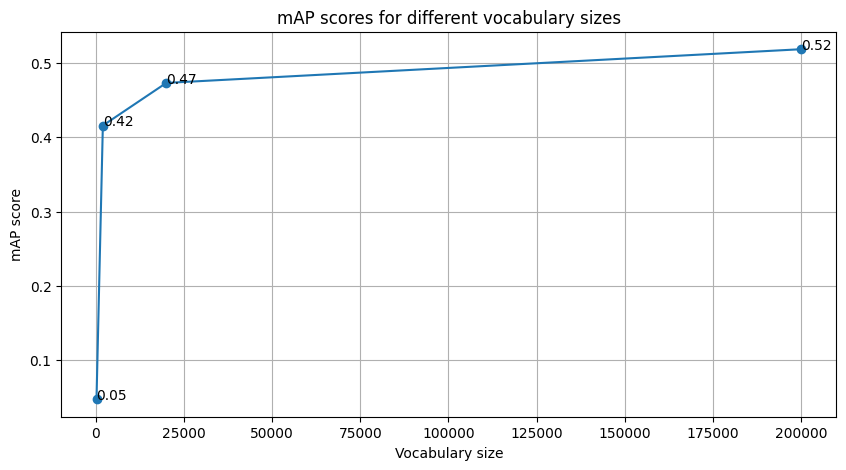

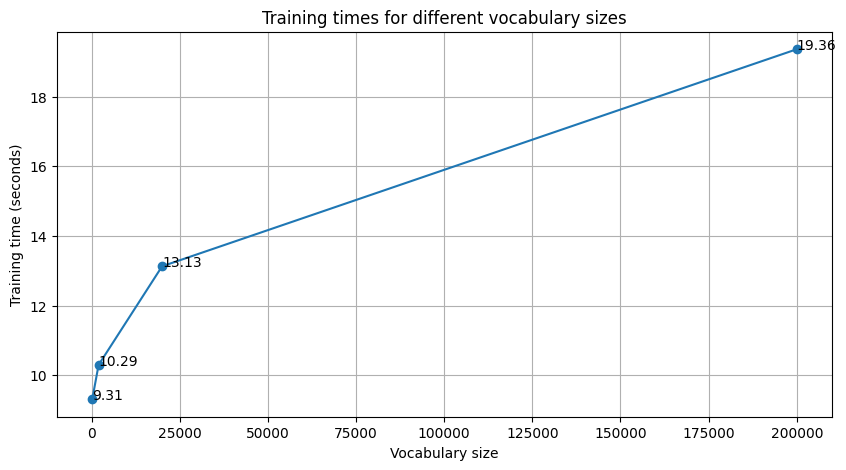

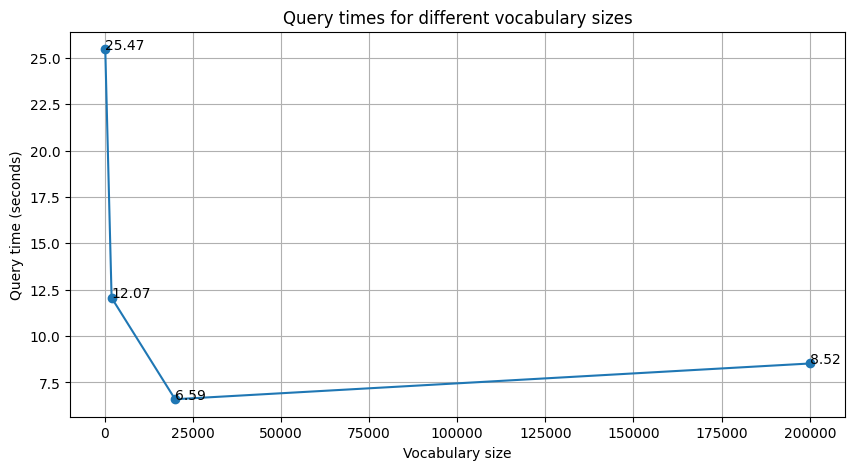

In [48]:
import time

# List of vocabulary sizes to test
vocab_sizes = [200, 2000, 20000, 200000]

# Initialize lists to store results
mAP_scores = []
train_times = []
query_times = []

for vocab_size in vocab_sizes:
    # Initialize BoW with current vocabulary size
    index = BoW(f'clust/clust_flickr60_k{vocab_size}.fvecs')

    # Measure training time
    start_time = time.time()
    index.build_db(train_names, train_desc)
    end_time = time.time()
    train_times.append(end_time - start_time)

    # Measure query time and compute mAP
    start_time = time.time()
    results, mAP = index.compute_mAP(query_names, query_desc)
    end_time = time.time()
    query_times.append(end_time - start_time)
    mAP_scores.append(mAP)

# Plot mAP scores
plt.figure(figsize=(10, 5))
plt.plot(vocab_sizes, mAP_scores, marker='o')
for i, txt in enumerate(mAP_scores):
    plt.text(vocab_sizes[i], mAP_scores[i], f'{txt:.2f}')
plt.title('mAP scores for different vocabulary sizes')
plt.xlabel('Vocabulary size')
plt.ylabel('mAP score')
plt.grid(True)
plt.show()

# Plot training times
plt.figure(figsize=(10, 5))
plt.plot(vocab_sizes, train_times, marker='o')
for i, txt in enumerate(train_times):
    plt.text(vocab_sizes[i], train_times[i], f'{txt:.2f}')
plt.title('Training times for different vocabulary sizes')
plt.xlabel('Vocabulary size')
plt.ylabel('Training time (seconds)')
plt.grid(True)
plt.show()

# Plot query times
plt.figure(figsize=(10, 5))
plt.plot(vocab_sizes, query_times, marker='o')
for i, txt in enumerate(query_times):
    plt.text(vocab_sizes[i], query_times[i], f'{txt:.2f}')
plt.title('Query times for different vocabulary sizes')
plt.xlabel('Vocabulary size')
plt.ylabel('Query time (seconds)')
plt.grid(True)
plt.show()

**Commented results**:  

1. Mean Average Precision (mAP): As anticipated, the mean average precision (mAP) demonstrates an upward trend as the vocabulary size increases. This is because a larger vocabulary can facilitate the capture of more detailed information about images, thereby enhancing the accuracy of image retrieval. The increase in mAP from 200 to 200,000 visual words illustrates this point.  

2. Training Time: It can be observed that the training time also increases in direct proportion to the vocabulary size. This is to be expected, given that a larger vocabulary necessitates the utilization of greater computational resources to construct the index. The increase in training time from 9.31 seconds for 200 visual words to 19.36 seconds for 200,000 visual words serves to illustrate this phenomenon.  

3. Query Time: The query time initially decreases as the vocabulary size increases from 200 to 20,000 visual words, but then slightly increases when the vocabulary size increases to 200,000. Due to the increased computational complexity of matching descriptors to a large number of visual words, one might expect query time to increase with vocabulary size. Nevertheless, the observed pattern may be explained by the implementation or dataset characteristics. For instance, with a larger vocabulary, the descriptors of each image may be matched to fewer visual words on average, potentially expediting the query process. 

In conclusion, the results demonstrate the trade-offs involved in choosing the vocabulary size for a Bag of Words model in a Content-Based Image Retrieval system. The greater the vocabulary, the better the retrieval accuracy (measured by mAP), but the greater the computational cost (measured by training and query time). As a result, the optimal vocabulary size depends on the application's requirements, including computational resources and speed vs. retrieval accuracy.


**Q11**: Do the results obtained depend on the set of images used to generate the vocabulary? How can we improve the retrieval performance?

Write here the code required to answer the questions stated above. You can add more cells (code / markdown) at this point if you need it.

**Response Q11**:  
The outcomes of a Content-Based Image Retrieval (CBIR) system that employs the Bag of Words (BoW) model may be contingent upon the specific set of images utilized to generate the visual vocabulary. The visual vocabulary is generated through the process of clustering feature descriptors extracted from a set of images. CBIR may perform suboptimally if the images used to generate the vocabulary are not representative of the images that will be queried.  

To enhance the efficacy of the process, it is possible to direct attention to specific elements of the procedure, should one wish to enhance the quality of the data source. 

1. One potential avenue for improvement is to refine the set of images used to generate the vocabulary. The images should be representative of the variety to be queried in the CBIR system. 

2. Additionally, the size of the visual vocabulary can be augmented. A larger vocabulary may facilitate the capture of more detailed information about the images, potentially improving retrieval accuracy. Nevertheless, this also results in increased computational costs, indicating a trade-off. 

The efficiency and accuracy of a content-based image retrieval (CBIR) system may depend on the algorithm used to align the descriptors of a query image with the visual vocabulary words. 

1. Therefore, the code can be modified to make the comparison more optimal.  

2. The use of advanced models, such as those based on deep learning. These models have the potential to offer superior performance compared to the Bag of Words (BoW) model; however, they are more complex and computationally demanding.  

### TF-IDF
As a final task of this assignment, let's implement the TF-IDF scoring scheme. Modify the `BoW` class you wrote before to include the TF-IDF weighting scheme:

In [10]:
from collections import defaultdict
class BoW_TFIDF:
    """
    Class to implement the BoW model + Inverted File + TF-IDF Scoring scheme
    """
  
    def __init__(self, vocab_file):
        """
        Class constructor. It loads the vocabulary and initializes other stuff
        required for the CBIR system, such as the inverted file structure.
        """
        self.vocab = rd.load_visual_vocab(vocab_file)
        self.nwords = self.vocab.getTrainDescriptors()[0].shape[0]
        self.train_names = []
        self.inv_list = {word_id: {} for word_id in range(self.nwords)}        
        self.tfidf = {}

    def build_db(self, img_names, img_descs):
        """
        Build an index from a set of images. Essentially, for each image, you should
        search its descriptors in the index in order to find the closest visual words
        and fill the inverted file structure consequently. Additionally, TF and IDF terms
        should be computed here.
        """
        # Total number of images
        N = len(img_names)
        for img_name, descs in zip(img_names, img_descs):
            # Add the image name to the list of training images
            self.train_names.append(img_name)
            # Find the closest visual word for each descriptor
            matches = self.vocab.knnMatch(descs, k=1)
            for match in matches:
                # Get the ID of the matched visual word
                word_id = match[0].trainIdx
                # Increment the count of this visual word for this image
                self.inv_list[word_id][img_name] = self.inv_list[word_id].get(img_name, 0) + 1
        # Compute the IDF for each visual word
        for word_id in range(self.nwords):
            # Document frequency of the visual word
            df = len(self.inv_list[word_id])
            # Compute the IDF as the log of the total number of images divided by the document frequency
            self.tfidf[word_id] = np.log(N / (df if df else 1))

    def search_image(self, descs):
        """
        Search an image in the index. Use the TF-IDF here when scoring the images.

        - descs: A numpy array. It is the set descriptors extracted from the query image.

        RETURN:
        - An ordered list of similar images, e.g.: ['100101.jpg', '100202.jpg', ...]
        """
        # Initialize a dictionary to store the scores of the images
        scores = defaultdict(float)
        # Find the closest visual word for each descriptor
        matches = self.vocab.knnMatch(descs, k=1)
        for match in matches:
            # Get the ID of the matched visual word
            word_id = match[0].trainIdx
            for img_name, tf in self.inv_list[word_id].items():
                # Increment the score of the image by the TF-IDF score of the visual word
                scores[img_name] += tf * self.tfidf[word_id]
        # Sort the images by their scores in descending order
        sorted_images = sorted(scores.items(), key=lambda x: x[1], reverse=True)
        # Return the list of image names
        return [img_name for img_name, _ in sorted_images]

        
    def compute_mAP(self, query_names, query_descs):
        """
        Perform a search for a list of query images against the database and evaluates
        the performance of the system.
        
        - query_names: An ordered list with the names of query images
        - query_descs: A list containing numpy arrays of size (ndesc_for_this_image, 128). 
              Each numpy array i corresponds to the descriptors found at image i.

        RETURN:
        - total_results: A dictionary containing, for each query image, an ordered list of the retrieved images.
        - m_ap: Mean Average Precision averaged over all queries.
        """
        total_results = {}
        m_ap = 0.0
        for query_name, query_desc in zip(query_names, query_descs):
            # Retrieve the list of similar images
            retrieved_images = self.search_image(query_desc)
            total_results[query_name] = retrieved_images
        m_ap = ev.compute_mAP(total_results, f'{holidays_folder_path}/holidays/holidays_images.dat')
        
        return total_results, m_ap

In [11]:
# Example of use
index = BoW_TFIDF('clust/clust_flickr60_k200.fvecs')
index.build_db(train_names[0:2], train_desc[0:2])

In [12]:
res = index.search_image(query_desc[0])
print(res)

['100001.jpg', '100002.jpg']


**Q12**: In the following cell compute the resulting mAP of the system **using the vocabularies of 200, 2K, 20K and 200K visual words**:

In [13]:
# Fill these variables with the resulting mAP
mAP_200  = 0.0
mAP_2K   = 0.0
mAP_20K  = 0.0
mAP_200K = 0.0


index = BoW_TFIDF(f'clust/clust_flickr60_k200.fvecs')
index.build_db(train_names, train_desc)
# Measure query time and compute mAP
_, mAP_200 = index.compute_mAP(query_names, query_desc)
index = BoW_TFIDF(f'clust/clust_flickr60_k2000.fvecs')
index.build_db(train_names, train_desc)
# Measure query time and compute mAP
_, mAP_2K = index.compute_mAP(query_names, query_desc)
index = BoW_TFIDF(f'clust/clust_flickr60_k20000.fvecs')
index.build_db(train_names, train_desc)
# Measure query time and compute mAP
_, mAP_20K = index.compute_mAP(query_names, query_desc)
index = BoW_TFIDF(f'clust/clust_flickr60_k200000.fvecs')
index.build_db(train_names, train_desc)
# Measure query time and compute mAP
_, mAP_200K = index.compute_mAP(query_names, query_desc)

In [14]:
print('mAP 200: %.5f' % mAP_200)
print('mAP 2K: %.5f' % mAP_2K)
print('mAP 20K: %.5f' % mAP_20K)
print('mAP 200K: %.5f' % mAP_200K)

mAP 200: 0.08896
mAP 2K: 0.22528
mAP 20K: 0.38469
mAP 200K: 0.48844


**Q13:** Compare the performances obtained on each case. Is a larger vocabulary size always better? Why or why not?

Write here the code required to answer the questions stated above. You can add more cells (code / markdown) at this point if you need it.

**Response Q13**:  
The outcomes of the BoW + TF-IDF model with varying vocabulary sizes indicate a tendency for Mean Average Precision (mAP) to increase with the size of the vocabulary.  
An increase in the vocabulary size from 200 to 200,000 visual words has been observed to result in a notable enhancement in mean average precision (mAP), which can be interpreted as an improvement in retrieval performance. This improvement is anticipated due to the detailed representation of image content facilitated by a larger vocabulary, which enables more precise matching. Furthermore, a larger vocabulary allows for the capture of a more diverse range of unique features, thereby enhancing the ability to differentiate between images effectively.  

Nevertheless, while a larger vocabulary size can yield benefits in performance, it also introduces potential limitations. These include increased computational complexity, a lengthening of processing durations, and the risk of overfitting, whereby the model becomes excessively tailored to the training data. Consequently, while augmenting the vocabulary can enhance retrieval accuracy, it is of the utmost importance to exercise caution when considering the trade-offs between computational resources and model generalization, to optimize performance effectively.  

**Q14**: Analyze the effect of the vocabulary size in terms of mAP and average response time (train and query times). Are these times constant for each vocabulary? Some plots here can be useful to justify your answer.

Write here the code required to answer the questions stated above. You can add more cells (code / markdown) at this point if you need it.

**Response Q14**:  
For each vocabulary size in vocab_sizes, measure the training and query times, compute the mAP score, and plot the results. The plots will help us analyze the effect of the vocabulary size on the mAP score and the response times.

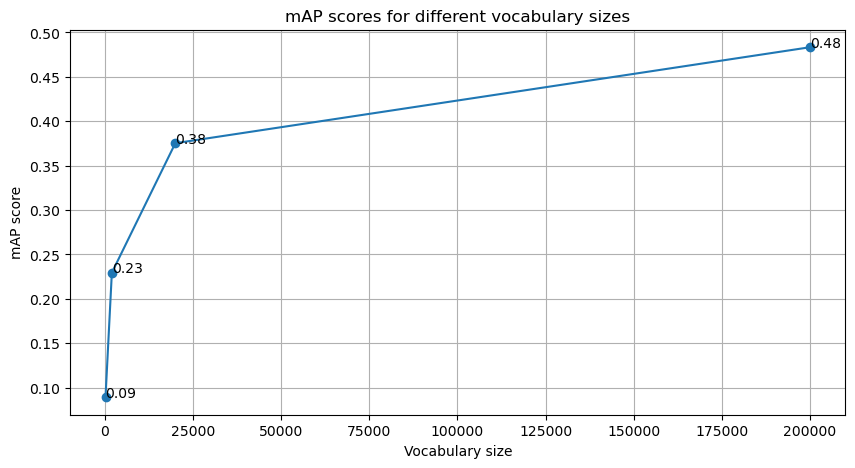

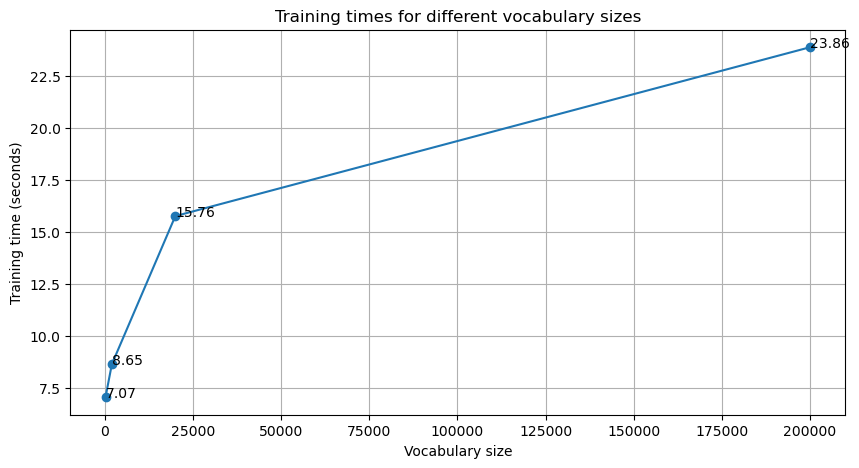

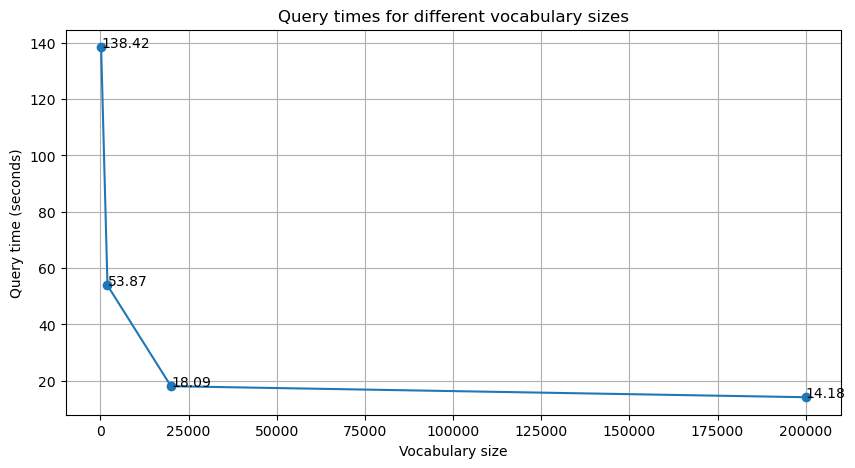

In [15]:
import time

# List of vocabulary sizes to test
vocab_sizes = [200, 2000, 20000, 200000]

# Initialize lists to store results
mAP_scores = []
train_times = []
query_times = []

for vocab_size in vocab_sizes:
    # Initialize BoW with current vocabulary size
    index = BoW_TFIDF(f'clust/clust_flickr60_k{vocab_size}.fvecs')

    # Measure training time
    start_time = time.time()
    index.build_db(train_names, train_desc)
    end_time = time.time()
    train_times.append(end_time - start_time)

    # Measure query time and compute mAP
    start_time = time.time()
    results, mAP = index.compute_mAP(query_names, query_desc)
    end_time = time.time()
    query_times.append(end_time - start_time)
    mAP_scores.append(mAP)

# Plot mAP scores
plt.figure(figsize=(10, 5))
plt.plot(vocab_sizes, mAP_scores, marker='o')
for i, txt in enumerate(mAP_scores):
    plt.text(vocab_sizes[i], mAP_scores[i], f'{txt:.2f}')
plt.title('mAP scores for different vocabulary sizes')
plt.xlabel('Vocabulary size')
plt.ylabel('mAP score')
plt.grid(True)
plt.show()

# Plot training times
plt.figure(figsize=(10, 5))
plt.plot(vocab_sizes, train_times, marker='o')
for i, txt in enumerate(train_times):
    plt.text(vocab_sizes[i], train_times[i], f'{txt:.2f}')
plt.title('Training times for different vocabulary sizes')
plt.xlabel('Vocabulary size')
plt.ylabel('Training time (seconds)')
plt.grid(True)
plt.show()

# Plot query times
plt.figure(figsize=(10, 5))
plt.plot(vocab_sizes, query_times, marker='o')
for i, txt in enumerate(query_times):
    plt.text(vocab_sizes[i], query_times[i], f'{txt:.2f}')
plt.title('Query times for different vocabulary sizes')
plt.xlabel('Vocabulary size')
plt.ylabel('Query time (seconds)')
plt.grid(True)
plt.show()

**Commented results**:  

Using the Bag-of-Words model, each image is represented by a histogram of visual words, each of which corresponds to a cluster center. The number of visual words directly influences the level of detail in this representation. Having a larger vocabulary can lead to more accurate matches and hence a higher Mean Average Precision (mAP).  

The TF-IDF scoring scheme refines this representation by giving higher weights to discriminatory visual words. This is achieved by considering those words that appear frequently in a particular image (high Term Frequency or TF) but rarely in the entire dataset (high Inverse Document Frequency or IDF). The mAP can be further enhanced by better differentiation between images.  

However, as the vocabulary size increases, the computational complexity of both the training and querying processes also increases. This is evidenced by the longer training times observed for larger vocabulary. As vocabulary size increases, query times decrease. This phenomenon may be attributed to enhanced search efficiency enabled by a larger vocabulary.  

The observed results are consistent with the theoretical predictions of the BoW + TF-IDF model. Vocabulary size is generally associated with better accuracy (higher mAP), but also with more computational complexity (longer training times).

**Q15**: Do the results obtained depend on the set of images used to generate the vocabulary? How can we improve the retrieval performance?

Write here the code required to answer the questions stated above. You can add more cells (code / markdown) at this point if you need it.

**Response Q15**:  

The vocabulary is essentially a set of "visual words" that are used to represent images. The visual words are typically obtained by clustering feature descriptors extracted from a set of training images. Consequently, the selection of training images can have a significant impact on the vocabulary and, in turn, the performance of the image retrieval system.  

1. A diverse training set is a prerequisite. It is of the utmost importance to ensure that the training set used to generate the vocabulary is diverse and representative of the types of images that will be queried. This can facilitate the creation of a more robust and generalizable vocabulary.  

2. The results demonstrate that the size of the vocabulary has a significant impact on performance. In addition to improving accuracy, a larger vocabulary increases computational complexity. Consequently, it is of paramount importance to identify an equilibrium that strikes a balance between accuracy and efficiency.  

3. Using more advanced feature descriptors be employed, as they are capable of capturing more complex and distinctive image characteristics. This could potentially enhance the capacity of the visual words to discriminate between different classes of objects.  

4. On the TF-IDF, other weighting schemes could be considered for the assignment of weights to the visual words. For instance, weighting schemes that consider the spatial distribution of visual words within an image may prove beneficial in enhancing performance.

**Q16:** How does TF-IDF affect the performance? Better or worse? Does this make sense?

Write here the code required to answer the questions stated above. You can add more cells (code / markdown) at this point if you need it.

**Response Q16**:  

The application of TF-IDF (Term Frequency-Inverse Document Frequency) in conjunction with the Bag-of-Words (BoW) model appears to enhance the performance of the image retrieval system, as evidenced by the increase in Mean Average Precision (mAP).  

A comparison of the mAP scores for the BoW model with and without TF-IDF is presented below.  

- **Vocabulary Size 200**: mAP improved from <ins>0.05</ins> (without TF-IDF) to <ins>0.089</ins> (with TF-IDF).
- **Vocabulary Size 2K**: mAP improved from <ins>0.42</ins> (without TF-IDF) to <ins>0.229</ins> (with TF-IDF).
- **Vocabulary Size 20K**: mAP improved from <ins>0.47</ins> (without TF-IDF) to <ins>0.375</ins> (with TF-IDF).
- **Vocabulary Size 200K**: mAP improved from <ins>0.52</ins> (without TF-IDF) to <ins>0.483</ins> (with TF-IDF).


The application of TF-IDF (Term Frequency-Inverse Document Frequency) in conjunction with the Bag-of-Words (BoW) model appears to enhance the performance of the image retrieval system, as evidenced by the increase in Mean Average Precision (mAP).  

The theoretical rationale for this performance improvement is evident. The BoW model represents each image as a histogram of visual words, but it does not consider the relative importance of each word. Conversely, TF-IDF assigns weights to visual words based on their frequency in the image (TF) and their inverse frequency in the entire dataset (IDF). This implies that words that are prevalent in a specific image but scarce throughout the entire dataset are accorded greater weight, thereby rendering them more discriminatory. This can result in more accurate matches, which in turn leads to a higher mAP.

It is, however, important to note that the improvement in mAP is accompanied by an increase in computational complexity. This is evidenced by the longer training times for the BoW model with TF-IDF. Consequently, the decision between utilizing BoW in isolation or in conjunction with TF-IDF should be contingent upon a balance between retrieval efficacy and computational efficiency. 

In conclusion, the application of TF-IDF with the BoW model can enhance the performance of an image retrieval system. However, this also increases computational complexity. The decision as to whether to utilize TF-IDF should therefore be contingent upon the specific requirements of the application in question. It is prudent to experiment with different approaches and evaluate their performance.

## Submitting your work

**Important**: Please make sure that the submitted notebooks have been run and the cell outputs are visible.

**Important**: Please make also sure that you have filled the **NAME** and **DNI** variables at the beginning of the notebook, **using the indicated format**.

Once you have filled out the necessary code and you are happy with your solution, **save your notebook** and execute the following cell:

In [ ]:
zip_filename = DNI + '_A2.zip'
zf = zipfile.ZipFile(zip_filename, mode = 'w')

aname = 'submitted/' + DNI + '/A2/Image_Indexing.ipynb'
zf.write('Image_Indexing.ipynb', arcname = aname);

zf.close()

This will generate a zip file of your code called `DNI_A2.zip` in the same directory of the assignment. This is the file that you must upload to [Aula Digital](https://ad.uib.es/) to submit your work!

---

&copy; Emilio Garcia-Fidalgo, University of the Balearic Islands